In [1]:
import time
import pandas as pd
from itertools import islice

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/10 20:04:20 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/10 20:04:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/10 20:04:21 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/10 20:04:21 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


'3.1.3'

In [3]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
# pip install --upgrade regex

In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import json
from itertools import combinations, takewhile
import collections

from google.cloud import storage
import io

In [8]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## Read dataset

In [9]:
# Read file
df = spark.read.json("gs://msca-bdp-tweets/final_project")

23/03/10 20:05:39 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/03/10 20:11:26 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
df.limit(5)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_in_countries
null,Sun Oct 02 22:30:...,"[7, 47]","{[], null, [], []...",null,null,0,false,low,null,1576701112446750720,1576701112446750720,Dream,1576700948722110464,1576700948722110464,183905912,183905912,false,en,null,null,0,null,null,null,null,null,0,0,,null,null,"<a href=""http://t...",@Dream ARE YOU KI...,1664749813554,false,@Dream ARE YOU KI...,"{false, Sat Jan 0...",null
null,Sun Oct 02 22:30:...,"[13, 140]","{[{[75, 92], Shar...",null,"{[13, 259], {[{[7...",0,false,low,null,1576701112593571842,1576701112593571842,yoonieshope,1576649576504623104,1576649576504623104,1313841518638137349,1313841518638137349,false,en,null,null,0,null,null,null,null,null,0,0,,guardiannews @the...,null,"<a href=""http://t...",@yoonieshope @gua...,1664749813589,true,@yoonieshope @gua...,"{false, Fri Jul 2...",null
null,Sun Oct 02 22:30:...,null,"{[], null, [], []...",null,null,0,false,low,null,1576701113067524096,1576701113067524096,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,AviMayer,"{null, Thu Sep 29...","<a href=""http://t...",RT @AviMayer: .@U...,1664749813702,false,.@UCBerkeley is a...,"{false, Thu Apr 0...",null
null,Sun Oct 02 22:30:...,null,"{[], null, [], []...",null,null,0,false,low,null,1576701113327554563,1576701113327554563,null,null,null,null,null,true,en,null,null,0,"{null, Sun Oct 02...",1576700948722110464,1576700948722110464,{twitter.com/drea...,Will be premierin...,0,0,,null,null,"<a href=""http://t...",that’s at half 1 ...,1664749813764,false,that’s at half 1 ...,"{false, Fri Dec 1...",null
null,Sun Oct 02 22:30:...,null,"{[{[57, 75], Shar...",null,null,0,false,low,null,1576701114644168704,1576701114644168704,null,null,null,null,null,true,en,null,null,0,"{null, Sun Oct 02...",1576588914445651968,1576588914445651968,{twitter.com/pour...,فوری حراست بچه‌ه...,0,0,RT,Alireza96554133,"{null, Sun Oct 02...","<a href=""http://t...",RT @Alireza965541...,1664749814078,false,Be the voice of s...,"{false, Sun Oct 0...",null


In [11]:
type(df)

pyspark.sql.dataframe.DataFrame

## Discard irrelevant tweets

In [12]:
# select relevant variables 
tweets = df.select(["id",lower(col("text")).alias("text"),"created_at","retweeted_status","user","place"])

In [13]:
# filter only the higher education topic
tweets = tweets.filter((tweets.text.contains("college"))
                       | (tweets.text.contains("student"))
                       | (tweets.text.contains("university"))
                       | (tweets.text.contains("undergraduate"))
                       | (tweets.text.contains("admission"))
                       | (tweets.text.contains("scholarship")))

In [14]:
tweets.show(5)

+-------------------+--------------------+--------------------+--------------------+--------------------+-----+
|                 id|                text|          created_at|    retweeted_status|                user|place|
+-------------------+--------------------+--------------------+--------------------+--------------------+-----+
|1529573746394247169|this morning, ric...|Wed May 25 21:22:...|                null|{false, Thu Aug 0...| null|
|1529573747077808129|rt @iraqveteran88...|Wed May 25 21:22:...|{null, Wed May 25...|{false, Sun Jan 3...| null|
|1529573750366248960|rt @realbrandongi...|Wed May 25 21:22:...|{null, Wed Apr 06...|{false, Sun Jan 1...| null|
|1529573762076577792|uof - 500 fashion...|Wed May 25 21:22:...|                null|{false, Fri Aug 1...| null|
|1529573767525158912|rt @shehusky: if ...|Wed May 25 21:22:...|{null, Wed May 25...|{false, Fri Nov 3...| null|
+-------------------+--------------------+--------------------+--------------------+--------------------

## Complete thorough EDA to identify which variables you can use to profile the Twitterers 

In [15]:
# check the structure of user column 
tweets.select("user").printSchema()

root
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- profile_background_color: string (nullable = true)
 |    |-- profile_background_image_url: string (nullable = true)
 |    |-- profile_background_image_url_https: string (nullable = true)
 |    |-- profile_background_tile: 

In [16]:
# base on the structure of user column, we choose relevant columns 
# id: basic info 
# name: basic info 
# location: where those Twitterers located
# verified: when an account is verified we know that it can be a celebrity, public figure, or brand. 
# description: short bio that is below the user's name, knowing this we can understand the user interest

# finally we drop the original column "user" to prevent redundant information 

tweets = tweets.withColumn("User_id", tweets["user"].getItem("id"))\
               .withColumn("User_name", tweets["user"].getItem("name"))\
               .withColumn("User_location", tweets["user"].getItem("location"))\
               .withColumn("User_verified", tweets["user"].getItem("verified"))\
               .withColumn("User_description", tweets["user"].getItem("description"))\
               .drop("user")

In [17]:
tweets.show(5)

+-------------------+--------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+-------------+--------------------+
|                 id|                text|          created_at|    retweeted_status|place|            User_id|           User_name|   User_location|User_verified|    User_description|
+-------------------+--------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+-------------+--------------------+
|1529573746394247169|this morning, ric...|Wed May 25 21:22:...|                null| null|          348289054|       Scott Sanford|      Dallas, TX|        false|Assignments Edito...|
|1529573747077808129|rt @iraqveteran88...|Wed May 25 21:22:...|{null, Wed May 25...| null|1487911724351168512|      Clark O Wilder|            null|        false|                null|
|1529573750366248960|rt @realbrandongi...|Wed May 25 21:22:...|{null, Wed Apr 06

In [18]:
# check the structure of created_at column 
tweets.select("created_at").printSchema()

root
 |-- created_at: string (nullable = true)



In [19]:
# check the created_at column 
# we want to split it into different column for better visualization and analysis when exploring the timelines of those tweets

tweets.select(col("created_at")).show(10, False)

+------------------------------+
|created_at                    |
+------------------------------+
|Wed May 25 21:22:53 +0000 2022|
|Wed May 25 21:22:54 +0000 2022|
|Wed May 25 21:22:54 +0000 2022|
|Wed May 25 21:22:57 +0000 2022|
|Wed May 25 21:22:58 +0000 2022|
|Wed May 25 21:23:02 +0000 2022|
|Wed May 25 21:23:02 +0000 2022|
|Wed May 25 21:23:03 +0000 2022|
|Wed May 25 21:23:03 +0000 2022|
|Wed May 25 21:23:04 +0000 2022|
+------------------------------+
only showing top 10 rows



In [20]:
# split the created_at into different columns 
# created_at, index, the length of the substring to extract 

tweets = tweets.withColumn("Week", substring("created_at", 1, 3)) \
               .withColumn("Month", substring("created_at", 5, 3)) \
               .withColumn("Day", substring("created_at", 9, 2)) \
               .withColumn("Time", substring("created_at", 12, 2)) \
               .withColumn("Year", substring("created_at", 27, 4)) \
               .drop("created_at")

In [21]:
tweets.show(5)

+-------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+-------------+--------------------+----+-----+---+----+----+
|                 id|                text|    retweeted_status|place|            User_id|           User_name|   User_location|User_verified|    User_description|Week|Month|Day|Time|Year|
+-------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+-------------+--------------------+----+-----+---+----+----+
|1529573746394247169|this morning, ric...|                null| null|          348289054|       Scott Sanford|      Dallas, TX|        false|Assignments Edito...| Wed|  May| 25|  21|2022|
|1529573747077808129|rt @iraqveteran88...|{null, Wed May 25...| null|1487911724351168512|      Clark O Wilder|            null|        false|                null| Wed|  May| 25|  21|2022|
|1529573750366248960|rt @realbrandongi...|{null, Wed Apr 06.

In [22]:
# create a organization column, group the Twitterers into different segments  
# where user_verified == true meaning 
# and user_description include the word  

tweets = tweets.withColumn("Organization",
           when((col("User_verified") == True) & (lower(col("User_description")).contains("gov")), "government entities") \
         .when((col("User_verified") == True) & (lower(col("User_description")).contains("school")), "schools") \
         .when((col("User_verified") == True) & (lower(col("User_description")).contains("news")), "news outlets") \
         .when((col("User_verified") == True) & (lower(col("User_description")).contains("universities")), "universities") \
         .when((col("User_verified") == True) & (lower(col("User_description")).contains("nonprofit")), "nonprofit organizations") \
         .when(col("User_verified") == True, "social media influencers") \
         .otherwise("other")) \
         .drop("User_verified")

In [23]:
tweets.show(5)

+-------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+
|                 id|                text|    retweeted_status|place|            User_id|           User_name|   User_location|    User_description|Week|Month|Day|Time|Year|Organization|
+-------------------+--------------------+--------------------+-----+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+
|1529573746394247169|this morning, ric...|                null| null|          348289054|       Scott Sanford|      Dallas, TX|Assignments Edito...| Wed|  May| 25|  21|2022|       other|
|1529573747077808129|rt @iraqveteran88...|{null, Wed May 25...| null|1487911724351168512|      Clark O Wilder|            null|                null| Wed|  May| 25|  21|2022|       other|
|1529573750366248960|rt @realbrandongi...|{null, Wed Apr 06...| n

In [24]:
# check the structure of retweeted_status column 
# tweets.select("retweeted_status").printSchema()

In [25]:
# base on the structure of retweeted_status column, we choose relevant columns 
# id: basic info 
# user id: basic info 
# retweet_count: useful when we need to calculate the total of retweet_count 
# is_retweet: see if the tweet is orginial or retweet 
# finally we drop the original column "retweeted_status" to prevent redundant information 

tweets = tweets.withColumn("retweeted_id", tweets["retweeted_status"].getItem("id")) \
               .withColumn("retweeted_user_id", tweets["retweeted_status"].getItem("user").getItem("id")) \
               .withColumn("retweeted_count", tweets["retweeted_status"].getItem("retweet_count")) \
               .withColumn("is_retweet", when(col("retweeted_id").isNull(), False).otherwise(True)) \
               .drop("retweeted_status")

In [26]:
tweets.show(5)

+-------------------+--------------------+-----+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+-------------------+-------------------+---------------+----------+
|                 id|                text|place|            User_id|           User_name|   User_location|    User_description|Week|Month|Day|Time|Year|Organization|       retweeted_id|  retweeted_user_id|retweeted_count|is_retweet|
+-------------------+--------------------+-----+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+-------------------+-------------------+---------------+----------+
|1529573746394247169|this morning, ric...| null|          348289054|       Scott Sanford|      Dallas, TX|Assignments Edito...| Wed|  May| 25|  21|2022|       other|               null|               null|           null|     false|
|1529573747077808129|rt @iraqveteran88...| null|1487911724351168512|

In [27]:
# tweets.select(col("place")).show(10, False)

In [28]:
# check the structure of place column 
tweets.select("place").printSchema()

root
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)



In [29]:
# base on the structure of place column, we choose relevant columns 
# name: basic info 
# country: basic info 
# place type: useful for filtering and categorizing tweets based on their location.
# coordinates: represent the location where the tweet was posted from
# finally we drop the original column "retweeted_status" to prevent redundant information 

tweets = tweets.withColumn("location_name", tweets["place"].getItem("name")) \
               .withColumn("location_country", tweets["place"].getItem("country")) \
               .withColumn("place_type", tweets["place"].getItem("place_type")) \
               .withColumn("coordinates", col("place.bounding_box.coordinates").alias("coordinates")) \
               .drop("place")

In [30]:
tweets.show(5)

+-------------------+--------------------+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+-------------------+-------------------+---------------+----------+-------------+----------------+----------+-----------+
|                 id|                text|            User_id|           User_name|   User_location|    User_description|Week|Month|Day|Time|Year|Organization|       retweeted_id|  retweeted_user_id|retweeted_count|is_retweet|location_name|location_country|place_type|coordinates|
+-------------------+--------------------+-------------------+--------------------+----------------+--------------------+----+-----+---+----+----+------------+-------------------+-------------------+---------------+----------+-------------+----------------+----------+-----------+
|1529573746394247169|this morning, ric...|          348289054|       Scott Sanford|      Dallas, TX|Assignments Edito...| Wed|  May| 25|  21|2022|       othe

In [31]:
# coordinates attribute is a nested list that contains the latitude and longitude values
# extract latitude and longitude 

tweets = tweets.withColumn("latitude", when(col("coordinates").isNull(), None).otherwise(tweets["coordinates"][0][0][1])).\
                withColumn("longitude", when(col("coordinates").isNull(), None).otherwise(tweets["coordinates"][0][0][0])).\
                drop("coordinates")

In [32]:
# final dataset structure 
tweets.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- User_id: long (nullable = true)
 |-- User_name: string (nullable = true)
 |-- User_location: string (nullable = true)
 |-- User_description: string (nullable = true)
 |-- Week: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Organization: string (nullable = false)
 |-- retweeted_id: long (nullable = true)
 |-- retweeted_user_id: long (nullable = true)
 |-- retweeted_count: long (nullable = true)
 |-- is_retweet: boolean (nullable = false)
 |-- location_name: string (nullable = true)
 |-- location_country: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [33]:
# remove missing values and count the number
tweets.dropna().count()

0

In [31]:
# tweets.limit(5)

## Identify the most prolific/influential Twitters

### original content

In [32]:
original = tweets.filter(col("is_retweet") == False) \
            .groupby(['User_id', 'User_name', 'Organization']) \
            .agg(count("id").alias('Total_count')) \
            .orderBy('Total_count', ascending=False) \
            .na.drop()

In [34]:
original.show(5)

+-------------------+--------------------+------------+-----------+
|            User_id|           User_name|Organization|Total_count|
+-------------------+--------------------+------------+-----------+
|          219401992|      Dennis Stemmle|       other|       9201|
| 879496394691805184|    EssayPaperUK.com|       other|       6286|
|1473922978073165834|      Study in Naija|       other|       6178|
|           73707872|India Education D...|       other|       5590|
|1472159008886870028|          Chuo Kikuu|       other|       5209|
+-------------------+--------------------+------------+-----------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import col, sum

In [39]:
# original_grouped = original.groupby(['Organization']) \
#                           .agg(sum('Total_count').alias('Total_count')) \
#                           .orderBy('Total_count')

In [42]:
# original_grouped_panda = original_grouped.toPandas()

<AxesSubplot:ylabel='Total_count'>

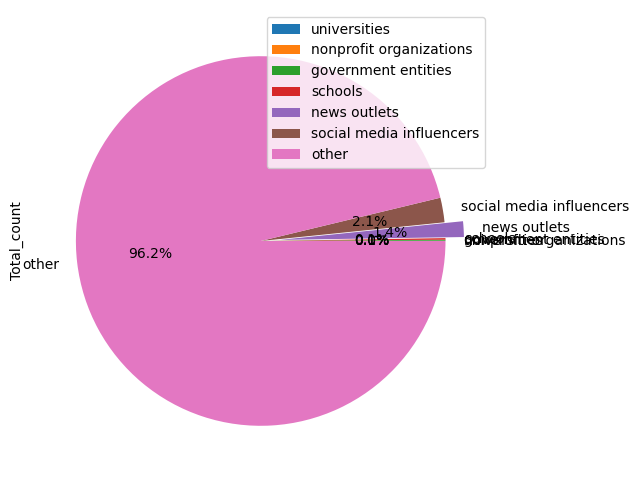

In [52]:
# original_grouped_panda.plot(kind='pie', y='Total_count', labels= original_grouped_panda['Organization'], autopct='%1.1f%%', figsize=(10,6), explode=(0, 0, 0, 0, 0.1, 0, 0))

Other has the highest total number of tweets. To better visualize other organization, we will drop the other and plot a new graph. 

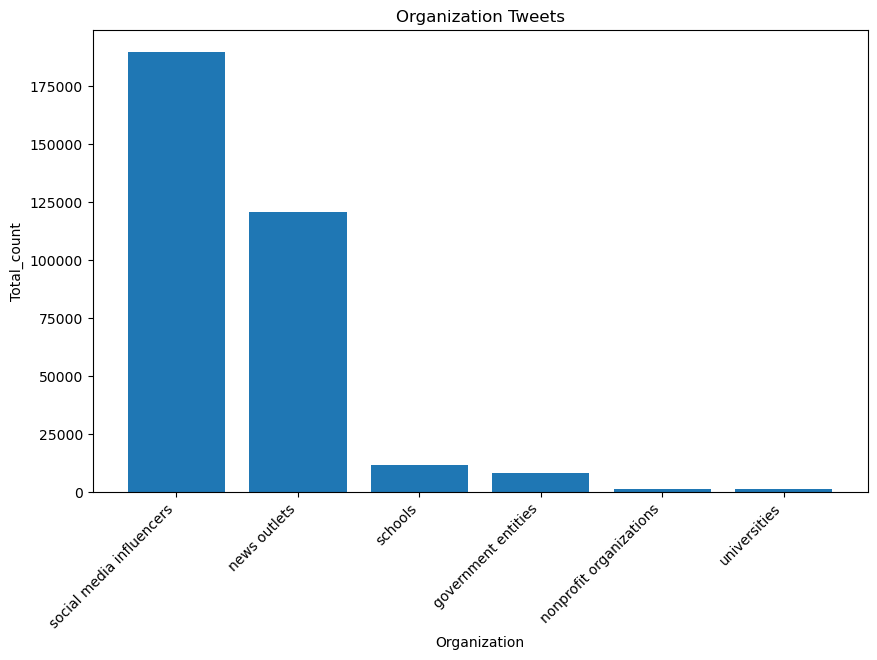

In [70]:
# filter out "other" category
original_filtered = original_grouped_panda[original_grouped_panda['Organization'] != 'other']

# sort by total count in descending order
original_filtered = original_filtered.sort_values(by='Total_count', ascending=False)

# create histogram
plt.figure(figsize=(10,6))
plt.bar(original_filtered['Organization'], original_filtered['Total_count'])
plt.xlabel('Organization')
plt.ylabel('Total_count')
plt.title('Organization Tweets')
plt.xticks(rotation=45, ha='right')

# show plot
plt.show()

### retweet content 

In [54]:
retweet = tweets.filter(col("is_retweet") == True) \
            .groupby(['User_id', 'User_name', 'Organization']) \
            .agg(count("id").alias('Total_count')) \
            .orderBy('Total_count', ascending=False) \
            .na.drop()

In [ ]:
retweet.show(5)

+-------------------+--------------------+------------+-----------+
|            User_id|           User_name|Organization|Total_count|
+-------------------+--------------------+------------+-----------+
|          152936614|          Joe Windon|       other|       4659|
|1295715136141963267|     Education World|       other|       2809|
|          195792808|               sarah|       other|       2407|
|1083852192539389952|Fanfictionwritert...|       other|       2404|
|1311337818518556672|Academic Opportun...|       other|       2178|
+-------------------+--------------------+------------+-----------+
only showing top 5 rows



In [57]:
from pyspark.sql.functions import col, sum

In [58]:
retweet_grouped = retweet.groupby(['Organization']) \
                          .agg(sum('Total_count').alias('Total_count')) \
                          .orderBy('Total_count')

In [59]:
retweet_grouped_panda = retweet_grouped.toPandas()

<AxesSubplot:ylabel='Total_count'>

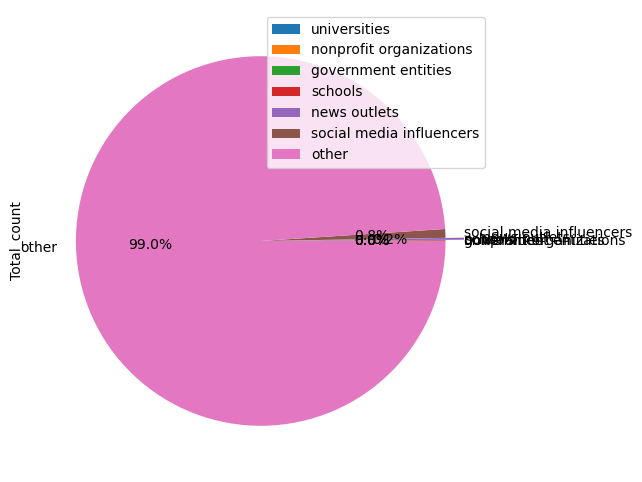

In [60]:
retweet_grouped_panda.plot(kind='pie', y='Total_count', labels= retweet_grouped_panda['Organization'], autopct='%1.1f%%', figsize=(10,6), explode=(0, 0, 0, 0, 0.1, 0, 0))

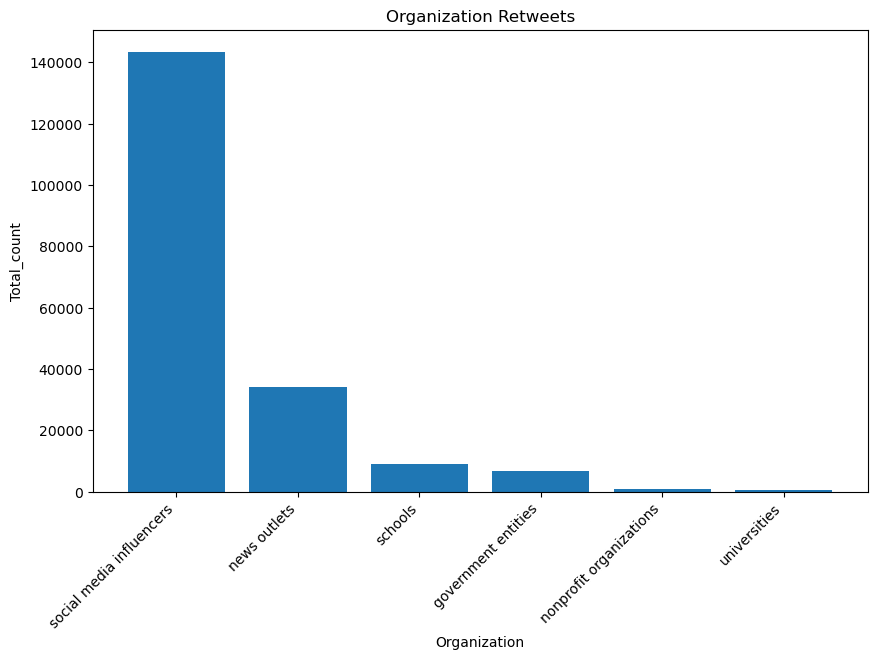

In [69]:
# filter out "other" category
retweet_filtered = retweet_grouped_panda[retweet_grouped_panda['Organization'] != 'other']

# sort by total count in descending order
retweet_filtered = retweet_filtered.sort_values(by='Total_count', ascending=False)

# create histogram
plt.figure(figsize=(10,6))
plt.bar(retweet_filtered['Organization'], retweet_filtered['Total_count'])
plt.xlabel('Organization')
plt.ylabel('Total_count')
plt.title('Organization Retweets')
plt.xticks(rotation=45, ha='right')

# show plot
plt.show()

## Location of twitterers 

In [33]:
from pyspark.sql.functions import count, first, col

location = tweets.groupby('User_id') \
                 .agg(count('id').alias('Total_count'),
                      first('User_name').alias('User_name'),
                      first('User_location').alias('Location')) \
                 .filter(col('Location').contains(', ')) \
                 .orderBy(col('Total_count').desc())

In [35]:
# location.show(5)

In [ ]:
location_name = tweets.groupby('location_name') \
                      .agg(count('id').alias('Total_count')) \
                      .dropna() \
                      .orderBy('Total_count', ascending=False) \
                      .limit(10) \
                      .toPandas()

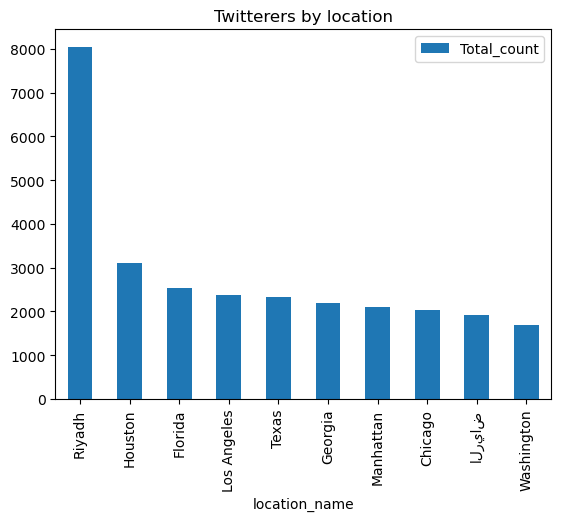

In [68]:
location_plot = location_name.plot(kind='bar', x='location_name', y='Total_count', title='Twitterers by location')

In [37]:
location_point = tweets.groupby(['latitude', 'longitude']) \
                       .agg(count('id').alias('Total_count')) \
                       .dropna() \
                       .orderBy('Total_count', ascending=False) \
                       .toPandas()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


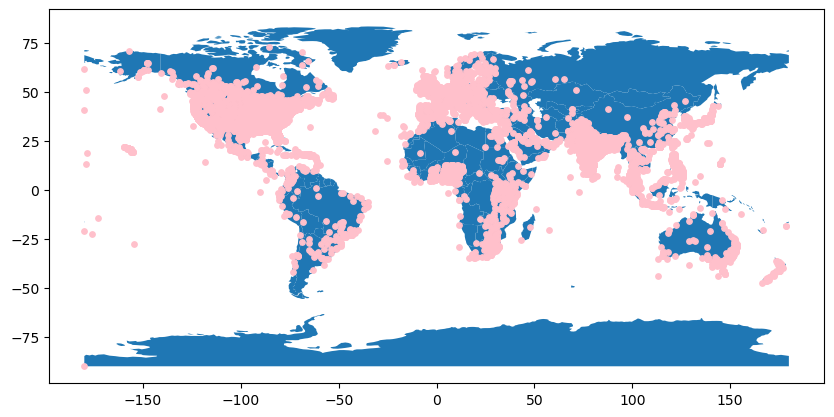

In [38]:
location_point = tweets.groupby(['latitude', 'longitude']) \
                       .agg(count('id').alias('Total_count')) \
                       .dropna() \
                       .orderBy('Total_count', ascending=False) \
                       .toPandas()

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
geography = [Point(xy) for xy in zip(location_point["longitude"],location_point["latitude"])]

geo_tweet = gpd.GeoDataFrame(location_point, geometry=geography)

world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_tweet.plot(ax=world_map.plot(figsize=(10, 6)), marker='o', color='pink', markersize=15);


## Timeline Analysis

### Month

In [43]:
month = tweets.groupby(['Month', 'Organization']) \
              .agg(count("id").alias('Total_count')) \
              .orderBy('Month') \
              .dropna() \
              .toPandas()

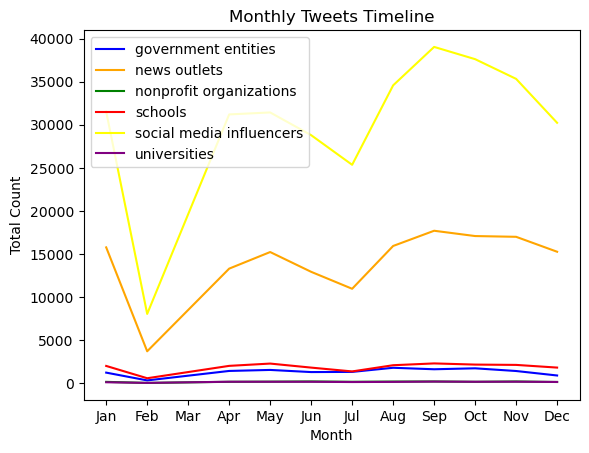

In [45]:
month['Month_num'] = pd.to_datetime(month['Month'], format='%b').dt.month
month_sorted = month[month['Organization'] != 'other'].sort_values(by=['Organization', 'Month_num'], ascending=True)

fig, ax = plt.subplots()
colors = ['blue', 'orange', 'green', 'red', 'yellow', 'purple']  
for i, organization in enumerate(month_sorted['Organization'].unique()):
    org_data = month_sorted[month_sorted['Organization'] == organization]
    ax.plot(org_data['Month_num'], org_data['Total_count'], color=colors[i % len(colors)], label=organization)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(pd.date_range(start='2022-01-01', end='2022-12-31', freq='MS').strftime('%b'))
ax.set_xlabel('Month')
ax.set_ylabel('Total Count')
ax.set_title('Monthly Tweets Timeline')
ax.legend()

plt.show()

### Week

In [40]:
week = tweets.groupby(['Week']) \
              .agg(count("id").alias('Total_count')) \
              .orderBy('Week') \
              .dropna() \
              .toPandas()

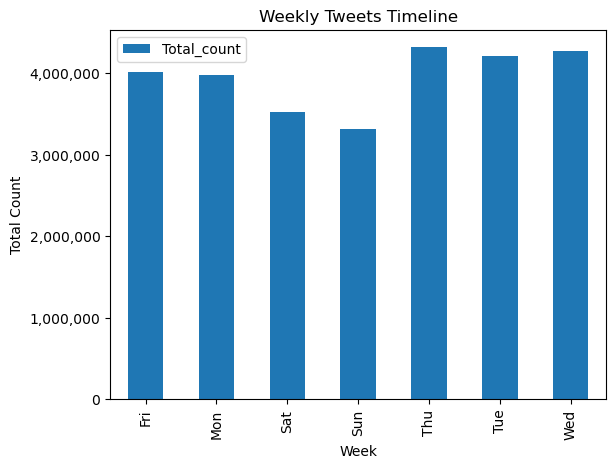

In [48]:
fig, ax = plt.subplots()
week.plot(kind='bar', x='Week', y='Total_count', ax=ax)

# Customize y-axis formatter to display full numbers
import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

ax.set_xlabel('Week')
ax.set_ylabel('Total Count')
ax.set_title('Weekly Tweets Timeline')

plt.show()

### Time 

In [49]:
time = tweets.groupby(['Time']) \
              .agg(count("id").alias('Total_count')) \
              .orderBy('Time') \
              .dropna() \
              .toPandas()

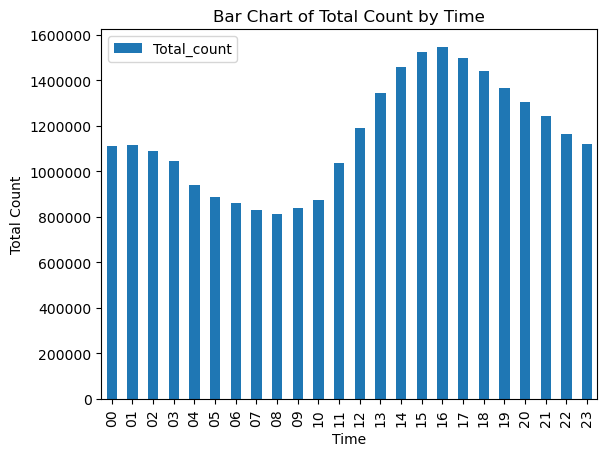

In [56]:
fig, ax = plt.subplots()
time.plot(kind='bar', x='Time', y='Total_count', ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Total Count')
ax.set_title('Bar Chart of Total Count by Time')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

## Tweets Similarity Analysis

### Government 

In [33]:
gov_raw = tweets.filter(col('Organization').contains('government')).select(['id','text'])

In [34]:
# clean the data and remove stopwords 
text = gov_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [35]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [36]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[#odiauniversity, #dhe, #obcc, @obcc_odisha, @dhe_odisha\ninfrastructure, development, work, for, odia, university, at, satyabad…, https://t.co/fbt15wpgsw]",0
1,"[rt, @usfws:, new, swim, move, --, bat, stroke.\n\n✨, believe, it, or, not..., bats, can, swim!, researchers, at, brown, university, used, high-resolution,, high-s…]",1
2,"[rt, @kheloindia:, 30km, #cyclothon, 🚴‍♂️🚴‍♀️, on, lines, with, #greengames, to, welcome, &amp;, create, awareness, on, #kheloindia, university, games, 2021, on, a…]",2
3,"[rt, @jaketapper:, fifteen, have, been, killed, in, shooting, at, robb, elementary, school,, according, to, governor, greg, abbott, 14, students, and, te…]",3
4,"[rt, @corbettsmithdmn:, the, last, mass, shooting, at, texas, school, happened, four, years, and, six, days, ago,, when, 10, students, were, killed, at, santa, f…]",4


In [37]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [ ]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [39]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[#odiauniversity, #dhe, #obcc, @obcc_odisha, @dhe_odisha\ninfrastructure, development, work, for, odia, university, at, satyabad…, https://t.co/fbt15wpgsw]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @usfws:, new, swim, move, --, bat, stroke.\n\n✨, believe, it, or, not..., bats, can, swim!, researchers, at, brown, university, used, high-resolution,, high-s…]",1,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @kheloindia:, 30km, #cyclothon, 🚴‍♂️🚴‍♀️, on, lines, with, #greengames, to, welcome, &amp;, create, awareness, on, #kheloindia, university, games, 2021, on, a…]",2,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @jaketapper:, fifteen, have, been, killed, in, shooting, at, robb, elementary, school,, according, to, governor, greg, abbott, 14, students, and, te…]",3,"(0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @corbettsmithdmn:, the, last, mass, shooting, at, texas, school, happened, four, years, and, six, days, ago,, when, 10, students, were, killed, at, santa, f…]",4,"(1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [40]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [41]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [42]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [43]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

23/03/10 17:02:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1042.2 KiB


,distCol,id_A,id_B,text_A,text_B
0,0.631579,1766,6470,"(new oig report about nsf: performance audit of incurred costs – university of maine https://t.co/dqoydddivx,)","(new report: performance audit of incurred costs – university of mississippi, november 18, 2022… https://t.co/vshplb0icp,)"
1,0.555556,4134,5501,"(rt @ddsportschannel: medal ceremony 🏅 athletics | men's discus throw | khelo india university games 2021\n\n#kheloindia | #kiug2021 https://t…,)","(rt @ddsportschannel: medals tally 🏅 khelo india university games 2021\n\n#kheloindia | #kiug2021 https://t.co/8sia5pf65c,)"
2,0.578947,4735,7344,"(rt @ddsportschannel: day 7 - khelo india university games 2021\n\nlive stream here 📲 https://t.co/a3klu5xkra\n\n#kheloindia | #kiug2021 https:/…,)","(rt @ddsportschannel: live men's boxing 🥊 khelo india university games 2021\n\nwatch here 📲 https://t.co/rcal9awerg\n\n#kheloindia | #kiug2021 h…,)"
3,0.619048,2378,4005,"(rt @ddsportschannel: medal ceremony 🏅men's kabaddi | khelo india university games 2021\n\nwatch here 📲 https://t.co/ap8gmpxwij\n\n#kheloindia |…,)","(rt @ddsportschannel: medal ceremony 🏅 women's 100m butterfly final | khelo india university games 2021\n\n#kheloindia | #kiug2021 https://t.c…,)"
4,0.166667,5779,7509,"(watch live 📡 7th convocation of indian maritime university, chennai. https://t.co/rmnmax22al,)","(rt @shipmin_india: watch live 📡 7th convocation of indian maritime university, chennai. https://t.co/rmnmax22al,)"


In [44]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  14699
Duplicate titles based on { 0.7 } jaccard distance:  2802
Unique titles based on { 0.7 } jaccard distance:  0.7 :  11897


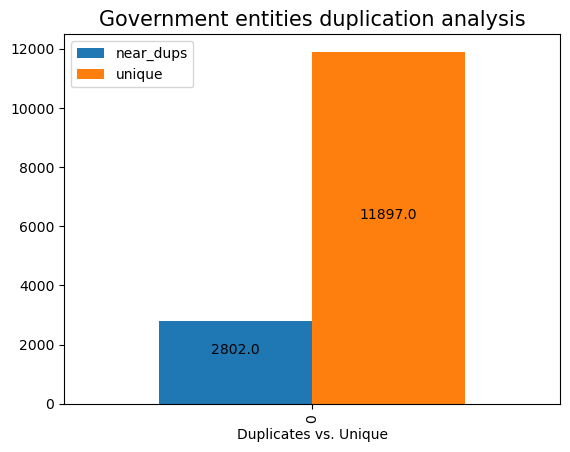

In [45]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government entities duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Universities 

In [46]:
uni_tweet = tweets.filter(col('Organization').contains('universities')).select(['id','text']).dropna()

In [47]:
# clean the data and remove stopwords 
text = uni_tweet.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [48]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [49]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @uakronadmission:, living, on, campus, is, one, of, the, most, exciting, parts, about, going, to, college., 🦘💙, the, housing, application, for, the, 2023-24…]",0
1,"[rt, @bravessports:, leslie, frazier, to, be, inducted, into, the, 14th, class, of, the, black, college, football, hall, of, fame, #fearthebrave, #forgingahead…]",1
2,"[according, to, study, cited, by, the, @nytimes,, of, the, top, 25, low-cost, college, towns, in, the, nation, are, in, wi:, la, cros…, https://t.co/gborqhydng]",2
3,"[seton, hall’s, college, of, nursing, receives, $3.6m, grant, for, mobile, health, clinic, training, https://t.co/swvxw2gkei, https://t.co/kvtad3ig74]",3
4,"[morehead, state, earns, college, of, distinction, recognition, in, multiple, categories, for, 2022-23:\n–, public, universities…, https://t.co/vmypqp4kpd]",4


In [50]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [ ]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [52]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @uakronadmission:, living, on, campus, is, one, of, the, most, exciting, parts, about, going, to, college., 🦘💙, the, housing, application, for, the, 2023-24…]",0,"(3.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @bravessports:, leslie, frazier, to, be, inducted, into, the, 14th, class, of, the, black, college, football, hall, of, fame, #fearthebrave, #forgingahead…]",1,"(2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[according, to, study, cited, by, the, @nytimes,, of, the, top, 25, low-cost, college, towns, in, the, nation, are, in, wi:, la, cros…, https://t.co/gborqhydng]",2,"(3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[seton, hall’s, college, of, nursing, receives, $3.6m, grant, for, mobile, health, clinic, training, https://t.co/swvxw2gkei, https://t.co/kvtad3ig74]",3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[morehead, state, earns, college, of, distinction, recognition, in, multiple, categories, for, 2022-23:\n–, public, universities…, https://t.co/vmypqp4kpd]",4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [53]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [54]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [55]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [56]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.481481,1004,1710,"(thank you to our co-founder and inductee, doug williams, for your generous support of the black college football ha… https://t.co/z84ydq3t1t,)","(thank you to our sponsor and class of 2022 inductee, nate newton, for your generous support of the black college fo… https://t.co/zclkv4lptu,)"
1,0.681818,964,1345,"(🏈 black college football hall of fame announces finalists for class of 2023 \n\nview full release here:… https://t.co/vsuyusn8dl,)","(leslie frazier headlines 2023 black college football hall of fame class\n\nhttps://t.co/3xhtajckri via @bleacherreport,)"
2,0.500000,183,403,"(2022 black college football player of the year award watch list: @tsutigersfb \n \ndraylen ellis (@draylen_ellis4)\nja… https://t.co/i1p9jygbmj,)","(2022 black college football player of the year award watch list: @famu_fb \n\nisaiah land (@isaiahland716)\nbj bohler… https://t.co/3ksnoqzx0j,)"
3,0.312500,789,1030,"(holiday shopping may look different this year, @esuniversity professor @eliassonus_eu tells @wnep: https://t.co/j389pyxxzw @esu_apscuf,)","(holiday shopping may look different this year, @esuniversity professor @eliassonus_eu tells @wnep:… https://t.co/96mlujq914,)"
4,0.652174,923,1619,"(congratulations to black college football hall of fame class of 2023 inductee elijah pitts 🏈… https://t.co/ohqc3vno9i,)","(bills coach leslie frazier named to 2023 black college football hall of fame https://t.co/7sg8sm1u7p via @sinow,)"


In [57]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1743
Duplicate titles based on { 0.7 } jaccard distance:  178
Unique titles based on { 0.7 } jaccard distance:  0.7 :  1565


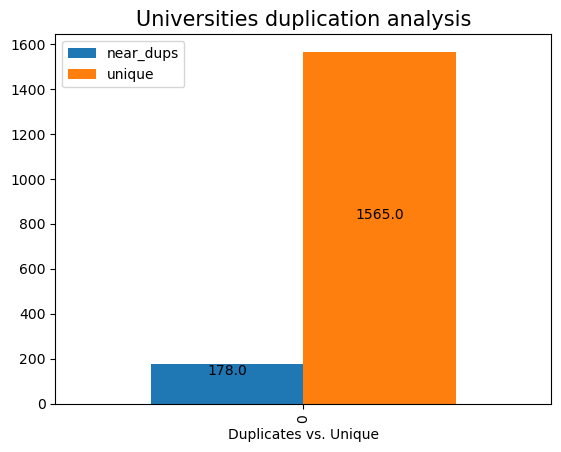

In [58]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Universities duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Nonprofit Organization 

In [59]:
org_tweet = tweets.filter(col('Organization').contains('nonprofit')).select(['id','text'])

In [60]:
# clean the data and remove stopwords 
text = org_tweet.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [61]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [62]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @studentsdemand:, we, refuse, to, go, on, like, this., walkout, thursday, 5/26., \n\ntext, walkout, to, 644-33, for, info, on, how, to, organize, walkout, at…]",0
1,"[rt, @bridgegood:, exhilarating, q1, for, #bridgegood, ⚡️, educated, 740+, students, from, 16, #bayarea, schools, with, #design, knowledge,, #career, guidance…]",1
2,"[this, is, what, the, observer, had, to, say, after, the, 1966, university, of, texas, tower, shooting., 54, years,, no, change.…, https://t.co/3pdcya5szp]",2
3,"[rt, @abtassociates:, what, key, elements, support, strong, partnerships, between, job, corps, and, community, colleges?\n\nread, insights, from, our, evaluati…]",3
4,"[rt, @dianalambert:, study, finds, college, president, searches, favor, white, men, and, offers, strategies, to, change, that, https://t.co/x5kbkqknri, via, @…]",4


In [63]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [64]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [65]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @studentsdemand:, we, refuse, to, go, on, like, this., walkout, thursday, 5/26., \n\ntext, walkout, to, 644-33, for, info, on, how, to, organize, walkout, at…]",0,"(0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @bridgegood:, exhilarating, q1, for, #bridgegood, ⚡️, educated, 740+, students, from, 16, #bayarea, schools, with, #design, knowledge,, #career, guidance…]",1,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[this, is, what, the, observer, had, to, say, after, the, 1966, university, of, texas, tower, shooting., 54, years,, no, change.…, https://t.co/3pdcya5szp]",2,"(2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @abtassociates:, what, key, elements, support, strong, partnerships, between, job, corps, and, community, colleges?\n\nread, insights, from, our, evaluati…]",3,"(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @dianalambert:, study, finds, college, president, searches, favor, white, men, and, offers, strategies, to, change, that, https://t.co/x5kbkqknri, via, @…]",4,"(0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [66]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [67]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [68]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [ ]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.647059,755,1208,"(technical consultant, process consultant - university of maryland - college park, md https://t.co/wldgv60vhj,)","(it senior engineer windows systems senior engineer - university of maryland - college park, md https://t.co/vcbvivkxwu,)"
1,0.615385,807,1193,"(rt @sbanchero: new!! the college completion strategy guide from @mdrc_news, @sheeoed, @edtrust &amp; @ticas_org offers recs to policymakers on…,)","(new! the college completion strategy guide from @sheeoed, @edtrust, @ticas_org, &amp; mdrc offers recommendations to po… https://t.co/zj6ewstpgk,)"
2,0.629630,1374,1758,"(this week's #studentspotlight is shining on our high school senior rose, who will be attending @baruchcollege in th… https://t.co/apo0mdcyz5,)","(this week's #studentspotlight is on our high school graduate sherlyn (far left) who will has started @instudiohcla… https://t.co/b68jt1axyk,)"
3,0.238095,125,184,"(see how students in your area performed on the caaspp/@smarterbalanced tests with our interactive database, where y… https://t.co/i861enncvc,)","(see how students in your area performed on the caaspp/smarter balanced tests with our interactive database, where y… https://t.co/sioms4pup3,)"
4,0.500000,619,656,"(rt @njhivstdline: ‘unsafe, unwelcoming’: #lgbtq students report facing hostility at #school @chalkbeat \n👇\nhttps://t.co/yt5cd9yeqh\n\nscan cod…,)","(rt @youthdriven: ‘unsafe, unwelcoming’: lgbtq students report facing hostility at school @chalkbeat https://t.co/yzxsrb5p03\n\n@standwithtrans,)"


In [70]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1930
Duplicate titles based on { 0.7 } jaccard distance:  234
Unique titles based on { 0.7 } jaccard distance:  0.7 :  1696


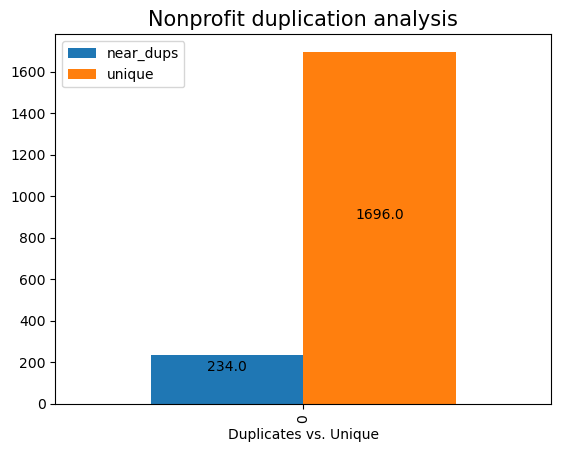

In [75]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Nonprofit duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

## Schools

In [72]:
sch_tweet = tweets.filter(col('Organization').contains('schools')).select(['id','text'])

In [73]:
# clean the data and remove stopwords 
text = sch_tweet.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [74]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [76]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[one, of, my, favorite, things, about, college, baseball, is, that, the, head, coach, of, one, of, the, most, prominent, programs, in, th…, https://t.co/3tmitbhqae]",0
1,"[another, school, shooting., this, time, in, #texas., 14, students,, teacher, dead., suspected, gunman, killed.…, https://t.co/ycsbjnohix]",1
2,"[what, great, year., it, was, blessing, to, be, back, in, schools, inspiring, students, and, staff., this, may, have, been, my, favo…, https://t.co/1hokr9d1pc]",2
3,"[rt, @larryferlazzo:, shooter, brings, death, to, another, school, here, are, resources, to, help, our, students, https://t.co/4dtqifyvt8]",3
4,"[rt, @achievethecore:, in, this, lesson, on, @sharemylesson,, middle-school, students, explore, poetry, and, songs, about, injustice,, reflect, on, what, issu…]",4


In [77]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [78]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [79]:
df_vectorize.limit(5).toPandas()

23/03/10 18:20:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1081.9 KiB
23/03/10 18:21:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1081.9 KiB


,list_of_words,id,features
0,"[one, of, my, favorite, things, about, college, baseball, is, that, the, head, coach, of, one, of, the, most, prominent, programs, in, th…, https://t.co/3tmitbhqae]",0,"(2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[another, school, shooting., this, time, in, #texas., 14, students,, teacher, dead., suspected, gunman, killed.…, https://t.co/ycsbjnohix]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[what, great, year., it, was, blessing, to, be, back, in, schools, inspiring, students, and, staff., this, may, have, been, my, favo…, https://t.co/1hokr9d1pc]",2,"(0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @larryferlazzo:, shooter, brings, death, to, another, school, here, are, resources, to, help, our, students, https://t.co/4dtqifyvt8]",3,"(0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @achievethecore:, in, this, lesson, on, @sharemylesson,, middle-school, students, explore, poetry, and, songs, about, injustice,, reflect, on, what, issu…]",4,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [80]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [81]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [82]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [83]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

23/03/10 18:21:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1109.9 KiB
23/03/10 18:29:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1195.0 KiB
23/03/10 18:29:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1195.1 KiB
23/03/10 18:29:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1297.8 KiB
23/03/10 18:31:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1215.4 KiB


,distCol,id_A,id_B,text_A,text_B
0,0.500000,17724,20139,"(rt @udogathletics: 🏀 boys final university 50 rcs 63 @chsaa @coloradopreps @1310prepsradio @bobbydfernandez,)","(rt @udogathletics: 🏀girls final university 45 severance 36 @chsaa @bobbydfernandez @coloradopreps @1310prepsradio,)"
1,0.000000,14754,18896,"(rt @deangeliscorey: breaking: arizona senate just passed a bill to fund students instead of systems.\n\nthis will be the most expansive schoo…,)","(rt @deangeliscorey: breaking: arizona senate just passed a bill to fund students instead of systems.\n\nthis will be the most expansive schoo…,)"
2,0.666667,10861,19294,"(rt @mattbrooksjr: blessed to receive my first division 1 offer from duquesne university !!! huge thanks to @coachgribbin @coachfarisonduq @…,)","(rt @touchm0ney7: extremely blessed and honored to receive my first offer from florida a&amp;m university @coach2bless @famu_fb @hcwilliesimmons…,)"
3,0.677419,10915,14756,"(rt @daviddavis791: after a great talk with @coachterrypsu im blessed to receive my 1st d1 offer to play at the university of penn state 🔵⚪️…,)","(rt @jay1kae: after a great conversation with @alex__townsend4 i’m blessed to receive my second offer from mercyhurst university ! 💚 | @coac…,)"
4,0.653846,8010,17011,"(rt @tremcleod13: blessed to receive an offer from university of maryland! #goterps🐢 @umdcoachbrooks @edobriencfb @rivalsfriedman @briandohn…,)","(rt @noahmikhail3: blessed to receive an offer from the university of california los angeles! #gobruins #4sup \n\n@uclafootball \nchip kelly\nke…,)"


In [84]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 18:31:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1157.6 KiB
23/03/10 18:31:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1222.2 KiB
23/03/10 18:31:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1229.2 KiB


Total records:  20658
Duplicate titles based on { 0.7 } jaccard distance:  3442
Unique titles based on { 0.7 } jaccard distance:  0.7 :  17216


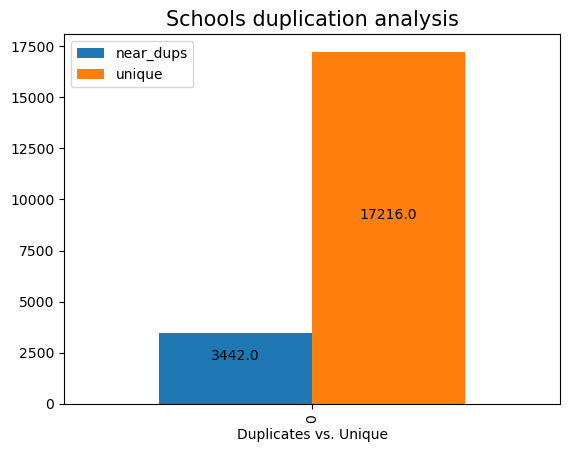

In [85]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Schools duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

## News outlet

In [34]:
new_tweet = tweets.filter(col('Organization').contains('news')).select(['id','text'])

In [35]:
new_tweet.count()

154914

In [36]:
news_tweet2 = new_tweet.sample(False, 0.1, seed=0)

In [38]:
# clean the data and remove stopwords 
text = news_tweet2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [ ]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [40]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[nyk, sessock, was, tense, in, the, days, leading, up, to, the, spring, 2021, college, cup., he, started, 17, matches, for, the, universi…, https://t.co/zon72fqly5]",0
1,"[u.s., president, joe, biden, and, the, first, lady, have, visited, the, scene, of, the, texas, school, shooting,, where, 19, students…, https://t.co/rucyryqjgf]",1
2,"[schools, in, the, districts, will, close, on, nov., so, employees, and, age-eligible, students, can, have, the, opportunity, to, go…, https://t.co/6zgtda5zjb]",2
3,"[rt, @smequbal:, shibli, college, student, union, president, abdur, rahman, has, been, arrested, by, the, azamgarh, police.i, condemn, this, and, demand, @azamg…]",3
4,"[local, high, school, students, make, documentary, on, what, it, was, like, being, part, of, the, “covid, cohort.”, ctv, london’s, br…, https://t.co/7hgqqpcszg]",4


In [41]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [42]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [43]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[nyk, sessock, was, tense, in, the, days, leading, up, to, the, spring, 2021, college, cup., he, started, 17, matches, for, the, universi…, https://t.co/zon72fqly5]",0,"(3.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[u.s., president, joe, biden, and, the, first, lady, have, visited, the, scene, of, the, texas, school, shooting,, where, 19, students…, https://t.co/rucyryqjgf]",1,"(3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[schools, in, the, districts, will, close, on, nov., so, employees, and, age-eligible, students, can, have, the, opportunity, to, go…, https://t.co/6zgtda5zjb]",2,"(2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @smequbal:, shibli, college, student, union, president, abdur, rahman, has, been, arrested, by, the, azamgarh, police.i, condemn, this, and, demand, @azamg…]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[local, high, school, students, make, documentary, on, what, it, was, like, being, part, of, the, “covid, cohort.”, ctv, london’s, br…, https://t.co/7hgqqpcszg]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [44]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [45]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [46]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [47]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

23/03/10 21:00:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1099.1 KiB
23/03/10 21:02:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1016.7 KiB


,distCol,id_A,id_B,text_A,text_B
0,0.681818,5779,11951,"(3 women arrested after police say they fought 2 students, 1 teacher at nc high school https://t.co/itibge65er,)","(a student was arrested wednesday after school officials say they found a gun at huffman high school.\n\nhttps://t.co/e9eqq7osza,)"
1,0.625000,3914,8658,"(the family of the suspect charged with the murders of four university of idaho students has spoken out for the firs… https://t.co/4gswjjcvqf,)","(the suspect arrested in connection with the murders of four university of idaho students appeared in court tuesday… https://t.co/ar9eucfbca,)"
2,0.538462,1877,4592,"(rt @meganmmenchaca: breaking: the stephen f. austin university (@sfasu) board of regents have voted to join the @utsystem.\n\nthe texas legis…,)","(stephen f. austin state university’s board of regents has voted to join the university of texas system, after ut's… https://t.co/guzrlz55qq,)"
3,0.696970,6679,11352,"(rt @nbcnews: the three university of virginia football players who were killed in a shooting last month have been honored with posthumous d…,)","(rt @nbcnews: breaking: student suspected in shooting at the university of virginia that left three members of the football team dead and tw…,)"
4,0.681818,6790,11525,"(espn’s college gameday announced they will be coming to jackson state for the first time. https://t.co/kyvig5fe9i,)","(college gameday is coming to kansas for the first time next week! https://t.co/9edoqsaqh6,)"


In [48]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 21:03:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1023.5 KiB
23/03/10 21:03:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1029.8 KiB


Total records:  15481
Duplicate titles based on { 0.7 } jaccard distance:  1309
Unique titles based on { 0.7 } jaccard distance:  0.7 :  14172


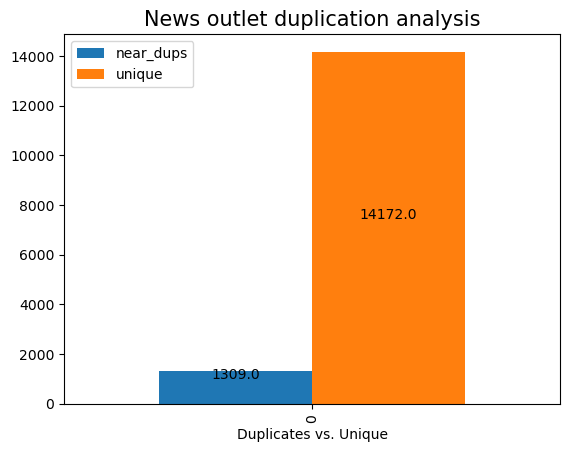

In [49]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News outlet duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

## Social Media 

In [62]:
media_tweet = tweets.filter(col('Organization').contains('media')).select(['id','text'])

In [63]:
media_tweet2 = media_tweet.sample(False, 0.01, seed=0)

In [64]:
# clean the data and remove stopwords 
text = media_tweet2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

23/03/10 21:45:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1834.1 KiB
Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [65]:
row = Row('text')
df_text=text.map(row).zipWithIndex().toDF(['text','id'])

In [54]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[this, is, horrific., 14, students, &amp;, one, teacher, killed, in, an, elementary, school, shooting., my, wife, is, 5th, grade, public…, https://t.co/aamaidkmlv]",0
1,"[@rexandthechief, love, the, sport, and, always, have., college, baseball, is, without, doubt, the, most, fun, to, follow]",1
2,"[@amishdevgan, look, like, you, also, passed, out, from, from, same, college, as, modi, \n\ndon’t, you, know, \n\nm.p’s, don’t, need, pol…, https://t.co/haskvzzisg]",2
3,"[annual, college, fair, providing, $40, million, in, scholarships, through, oct., 27, cw, atlanta, https://t.co/mbkgagz4gp, https://t.co/8gobf03r0w]",3
4,"[rt, @kfdmnews:, breaking, update:, 18, students, and, adults, confirmed, dead, in, mass, shooting, at, robb, elementary, school, in, uvalde,, according, to, a…]",4


In [55]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [56]:
# Fit countvectorizer to create word features

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [57]:
df_vectorize.limit(5).toPandas()

23/03/10 21:26:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.6 KiB
23/03/10 21:26:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.6 KiB


,list_of_words,id,features
0,"[this, is, horrific., 14, students, &amp;, one, teacher, killed, in, an, elementary, school, shooting., my, wife, is, 5th, grade, public…, https://t.co/aamaidkmlv]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[@rexandthechief, love, the, sport, and, always, have., college, baseball, is, without, doubt, the, most, fun, to, follow]",1,"(2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[@amishdevgan, look, like, you, also, passed, out, from, from, same, college, as, modi, \n\ndon’t, you, know, \n\nm.p’s, don’t, need, pol…, https://t.co/haskvzzisg]",2,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[annual, college, fair, providing, $40, million, in, scholarships, through, oct., 27, cw, atlanta, https://t.co/mbkgagz4gp, https://t.co/8gobf03r0w]",3,"(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @kfdmnews:, breaking, update:, 18, students, and, adults, confirmed, dead, in, mass, shooting, at, robb, elementary, school, in, uvalde,, according, to, a…]",4,"(0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [58]:
# Fit MinHashLSH to create hash table

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [59]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [60]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [ ]:
# df_dups_70 = df_dups_text
# df_dups_text.cache()
# #df_dups_text.limit(5).toPandas()

In [66]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 22:04:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1776.3 KiB
23/03/10 22:04:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1841.0 KiB
23/03/10 22:04:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1847.7 KiB


Total records:  33508
Duplicate titles based on { 0.7 } jaccard distance:  4355
Unique titles based on { 0.7 } jaccard distance:  0.7 :  29153


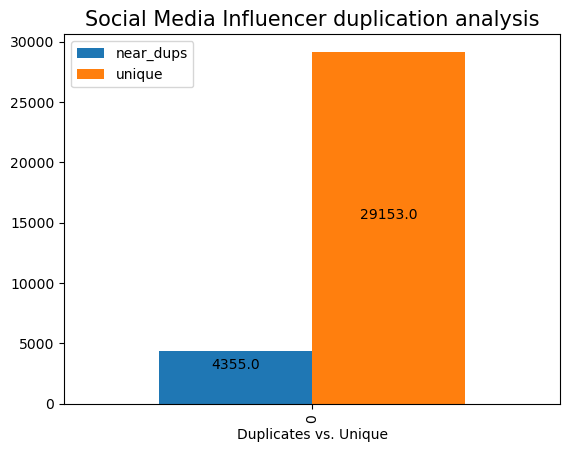

In [67]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Social Media Influencer duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 